---
 # Import and Intialize Libraries
---

The needed dependencies are as followed:

In [1]:
# Standard libraries
import time
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import timedelta

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns
import matplotx

The style used for matplot.pyplot visualizations:

In [2]:
plt.style.use(matplotx.styles.ayu['light'])

---
# Modeling a Stock Path
---

For modeling the path of a stock we will be assuming that stocks follow a Geometric Brownian Motion (Exponential Brownian Motion) with a constant drift $\mu$ and volatility $\sigma$.  

Based on the assumption the value of a stock at time $t$ will be described using the following stochastic differential equation (SDE):

$$dS_t = \mu S_tdt + \sigma S_tdW_t$$

Such that $W_t$ is Brownian Motion.

## Solving the SDE

To solve the stochastic differential equation we will be using Itô calculus. Itô calculus is a stochastic version of calculus. It is based on the Itô integral, which is a stochastic version of the Riemann-Stieltjes integral. The Itô integral is defined as:

$$Y_t = \int_0^t H dX$$

Where $Y_t$ is itself a stochastic process and where $H$ is a locally square-integrable process adapted to the filtration generated by $X$.

To solve thie SDE we will be using the Itô lemma for $d(lnS_t)$, such that:

$$d(lnS_t) = (lnS_t)'dS_t + \frac{1}{2}(ln S_t)" dS_{t}dS_t$$
$$d(lnS_t) = \frac{dS_t}{S_t} - \frac{1}{2S_t} dS_t dS_t$$

where $dS_t dS_t$ is the quadratic vartiation of the SDE.


$$dS_t dS_t = \sigma^2 S_{t}^2 dW_{t}^2 + 2\sigma S_{t}^2 \mu dW_t dt + \mu^2 S_{t}^2 dt^2$$
Which simplifies to:
$$dS_t dS_t = \sigma^2S_{t}^2 dt$$

When apply this transformations to the previous result and simplifying the solution, we get the following solution:
$$ln(\frac{S_t}{S_0}) = (\mu - \frac{\sigma^2}{2})t + \sigma W_t$$

Which generates the final solution as described using the formula:
$$S_t = S_0 \times \exp((\mu - \frac{\sigma^2}{2})t + \sigma W_t)$$

## Discretization

The discretized form of the preceding solution yields the following recurrence relation:

$$s_t = s_{t-1} \times \exp\left(\mu - \frac{\sigma^2}{2} \Delta t + \sigma Z\right)$$

Where $Z$ represents a random sample from the normal distribution $\mathcal{N}(0, \Delta t)$, and $\Delta t$ denotes the time interval between consecutive time points.


---

## Example of a simulated stock path

The parameters used to model the stock are as followed:

In [3]:
S0 = 100            # Initial stock price
K = 105             # Strike price
r = 0.05            # Risk-free interest rate
volatility = 0.2    # Annual volatility
T = 1               # Time to maturity (in years)

### Stock path generation

In [4]:
dt = T / 365
price_path = [S0]

for _ in range(365):
    z = np.random.standard_normal()
    price_path.append(price_path[-1] * np.exp((r - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * z))

### Visualization of the stock's price path

#### Regular plot

Plot of the stock price through time (1 year)

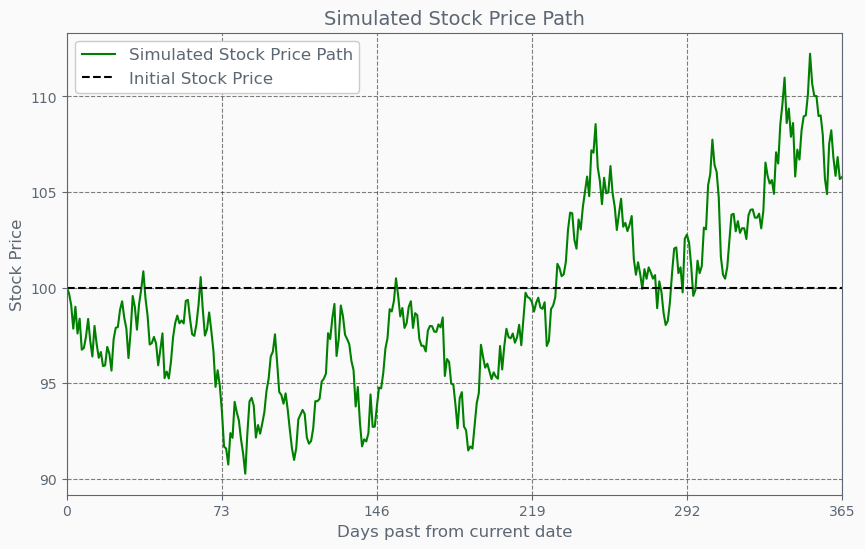

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(price_path, color=('g' if price_path[-1] > S0 else 'r'), label='Simulated Stock Price Path')
plt.axhline(y=S0, label='Initial Stock Price', color='black', linestyle='--')

# plt.ylim(80, 120)
# plt.yticks(np.arange(80, 121, 10))

plt.xlim(0, 365)
plt.xticks(np.arange(0, 366, 73))
plt.xlabel('Days past from current date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.title('Simulated Stock Price Path', fontsize=14)
plt.legend(loc=0, facecolor='white', framealpha=1, fontsize=12)
plt.grid(True, linestyle='--', color='black', alpha=0.5)
# plt.savefig('stock_price_path.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Candlestick Plot

More dynamic plot of a stock path through time (1 year)

In [6]:
# Function for Generating Candlestick Data from Stock Price Paths

def generate_candlestick_data(paths, number_of_days, start_timestamp=pd.Timestamp.now()):
    data = {
        'Timestamp': [start_timestamp + timedelta(hours=24 * i) for i in range(number_of_days + 1)],
        'Price': paths
    }

    candlestick_df = pd.DataFrame(data)
    candlestick_df['Timestamp'] = pd.to_datetime(candlestick_df['Timestamp'])
    candlestick_df['Close'] = candlestick_df['Price'].shift(-1)
    
    candlestick_df.dropna(inplace=True)
    
    candlestick_df['Open'] = candlestick_df['Price']
    candlestick_df['High'] = candlestick_df[['Open', 'Close']].max(axis=1)
    candlestick_df['Low'] = candlestick_df[['Open', 'Close']].min(axis=1)
    
    return candlestick_df[['Timestamp', 'Open', 'High', 'Low', 'Close']]

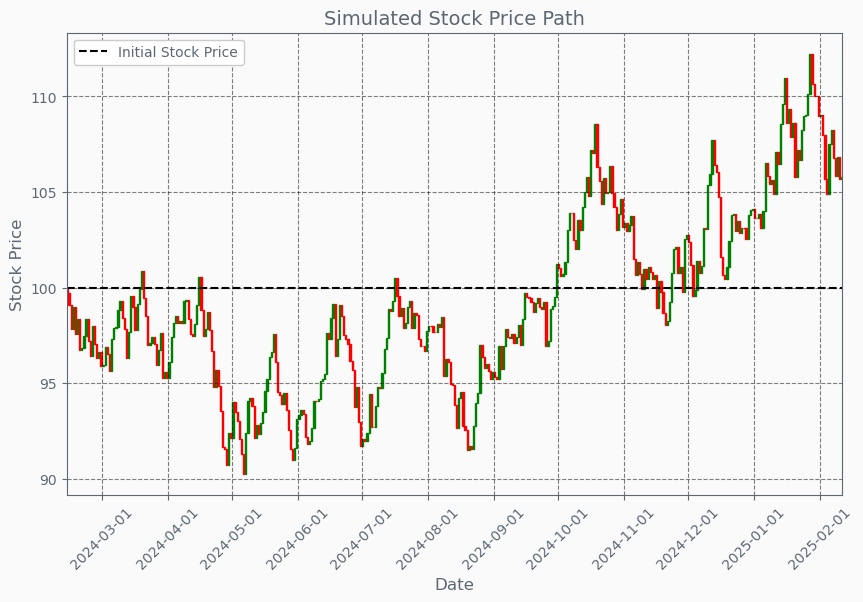

In [7]:
# Plotting Candlestick Data

fig, ax = plt.subplots(figsize=(10, 6))

df = generate_candlestick_data(price_path, 365)
df['Timestamp'] = df['Timestamp'].apply(lambda x: mdates.date2num(x))

candlestick_ohlc(ax, df.values, width=0.6, colorup='g', colordown='r')
plt.axhline(y=S0, color='black', linestyle='--', label='Initial Stock Price')
# plt.axhline(y=K, color='orange', linestyle='--', label='Strike Price')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# plt.ylim(90, 115)

plt.xticks(rotation=45)
plt.xlim(df['Timestamp'].min(), df['Timestamp'].max())

plt.title('Simulated Stock Price Path', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(loc=0, facecolor='white', framealpha=1)
plt.grid(True, linestyle='--', color='black', alpha=0.5)
# plt.savefig('candlestick_chart.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

---
# Options
---

An option is a financial instrument that gives the holder the right, but not the obligation, to buy or sell an underlying asset, such as a stock, at a predetermined price within a specified time period. The buyer of the option pays a premium to the seller, who takes on the obligation to fulfill the terms of the option if the buyer chooses to exercise it.

There are 2 types of options:
- call options (right to buy)
- put options (right to sell)

In this project we will focusing on European style Call Option, which gives the holder the right (but not the obligation) to buy an asset at a fixed price, the strike price $K$, at the expiry date $T$. The payoff of this type of option is calculated using the following method: 

$$\max(0, S(T) - K)$$

where $S(T)$ is the stock price at maturity $T$.

## Importance of Option Pricing

Option pricing is crucial in financial markets for several reasons:

- **Risk Management:** Enables investors to hedge against price fluctuations.
- **Investment Strategies:** Essential for executing options-based investment strategies.
- **Market Efficiency:** Contributes to market integrity by preventing arbitrage opportunities.
- **Capital Allocation:** Helps optimize portfolios by efficiently allocating capital.
- **Speculation:** Traders use option pricing to assess potential profits and risks in speculative activities.
- **Financial Engineering:** Foundation for creating new financial instruments and strategies.
- **Corporate Finance:** Important for valuing employee stock options, mergers, acquisitions, and overall corporate finance decisions.
- **Market Liquidity:** Enhances market liquidity by instilling confidence in option prices, attracting participants, and encouraging trading activity.

---
# Monte Carlo Simulation for Option Pricing
---

## Stock parameters

The parameters used to model the stock are as followed:

In [8]:
S0 = 100            # Initial stock price
K = 105             # Strike price
r = 0.05            # Risk-free interest rate
volatility = 0.2    # Annual volatility
T = 1               # Time to maturity (in years)

These parameters will be used for generating a simulation of a stock path.

## Simulation parameters

The parameters for the Monte Carlo simulation process are as follows:

In [9]:
num_simulations = 10000  # Number of paths / Number of Simulations
num_time_steps = 365    # Number of steps / Number of time intervals

---

## Monte Carlo Simulation of Stocks

### Basic Monte Carlo Simulation

In [10]:
start_time_std = time.time()

# Generate random stock price paths
np.random.seed(0)  # for reproducibility
dt = T / num_time_steps

# Simulate stock price paths
stock_price_paths = []
for _ in range(num_simulations):
    price_path = [S0]
    for _ in range(num_time_steps):
        z = np.random.standard_normal()
        price_path.append(price_path[-1] * np.exp((r - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * z))
    stock_price_paths.append(price_path)

end_time_std = time.time()

### Optimization of Simulation method using Pandas DataFrame

The Pandas DataFrame Approach uses vectorized operations for stock price path generation to lower the needed execution time.

In [11]:
start_time_pandas = time.time()

# Generate random stock price paths
np.random.seed(0)  # for reproducibility
dt = T / num_time_steps

# Simulate stock price paths
stock_price_paths_df = pd.DataFrame(np.full((num_simulations, 1), S0), columns=['0'])

columns = [f'{i}' for i in range(num_time_steps + 1)]

for i in range(1, num_time_steps + 1):
    z = np.random.standard_normal(num_simulations)
    coeff = np.exp((r - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * z)
    
    stock_price_paths_df = pd.concat([stock_price_paths_df, stock_price_paths_df[f'{i-1}'] * coeff], axis=1)
    stock_price_paths_df.columns = columns[:i+1]

end_time_pandas = time.time()

#### Improvement factor of Pandas method over Standard Loop method

In [39]:
loop_time = end_time_std - start_time_std
pandas_time = end_time_pandas - start_time_pandas

print(f'Loop time: {loop_time:.2f} sec')
print(f'Pandas time: {pandas_time:.2f} sec')

print(f'Improvement factor: {((loop_time - pandas_time) / loop_time * 100):.2f}%')

Loop time: 26.98 sec
Pandas time: 16.16 sec
Improvement factor: 40.10%


## Payoff Calculations

After the generation of simulated stock price paths, we can calculate the payoff of the option at maturity for each path.

In [13]:
# Calculate option payoffs
option_payoffs = [max(0, path[-1] - K) for path in stock_price_paths]

# Calculate the option price using Monte Carlo
option_price = np.exp(-r * T) * np.mean(option_payoffs)

## Visualization of Stock Price Paths

### All stock paths plot

<Figure size 1000x600 with 0 Axes>

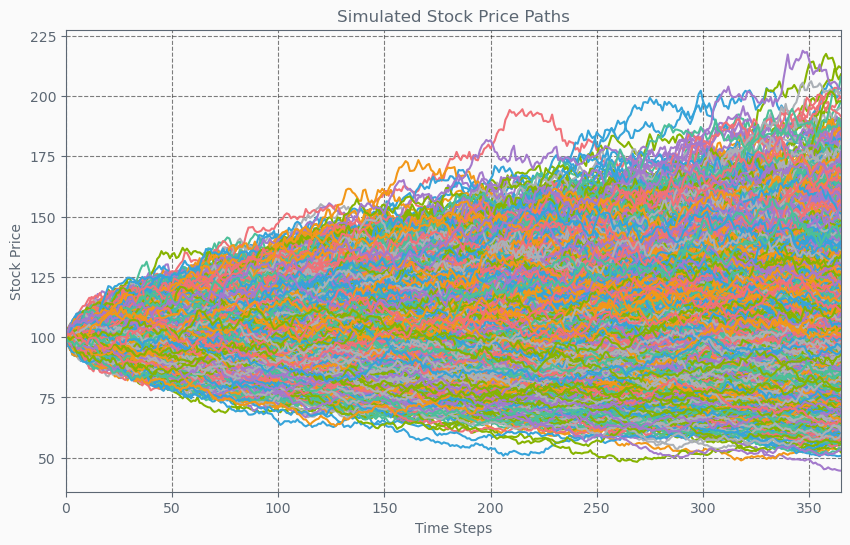

In [14]:
plt.figure(figsize=(10, 6))

stock_price_paths_df.T.plot(legend=False, figsize=(10, 6))

plt.xlim(0, num_time_steps)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Simulated Stock Price Paths")
plt.grid(True, linestyle='--', color='black', alpha=0.5)
plt.show()

### Summarised plot

Plot of the mean value ($\pm 2$ std. dev.) of the simulated stock price path.

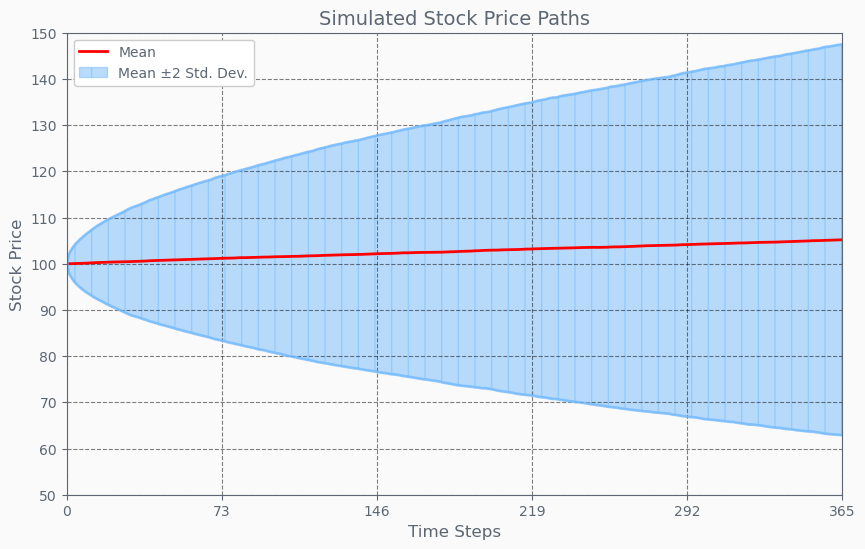

In [38]:
aggregate_df = stock_price_paths_df.agg(['mean', 'std']).T

plt.figure(figsize=(10, 6))

sns.lineplot(data=aggregate_df['mean'], label='Mean', color='r', linewidth=2)
plt.fill_between(
    aggregate_df['mean'].index, 
    aggregate_df['mean'] - 2*aggregate_df['std'], 
    aggregate_df['mean'] + 2*aggregate_df['std'], 
    color='#75bbfd',
    alpha=0.5,
    hatch='|',
    label='Mean ±2 Std. Dev.',
)

sns.lineplot(data=aggregate_df['mean'] - 2*aggregate_df['std'], color='#75bbfd', linewidth=2, alpha=0.8)
sns.lineplot(data=aggregate_df['mean'] + 2*aggregate_df['std'], color='#75bbfd', linewidth=2, alpha=0.8)

plt.ylim(50, 150)
plt.yticks(np.arange(50, 151, 10))

plt.xlim(0, num_time_steps)
plt.xticks(np.arange(0, num_time_steps + 1, 73))

plt.legend(loc='upper left', facecolor='white', framealpha=1)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.title('Simulated Stock Price Paths', fontsize=14)
plt.grid(True, linestyle='--', color='black', alpha=0.5)
# plt.savefig('stock_price_paths_aggregate.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Visualization of the Distribution of Option Payoffs

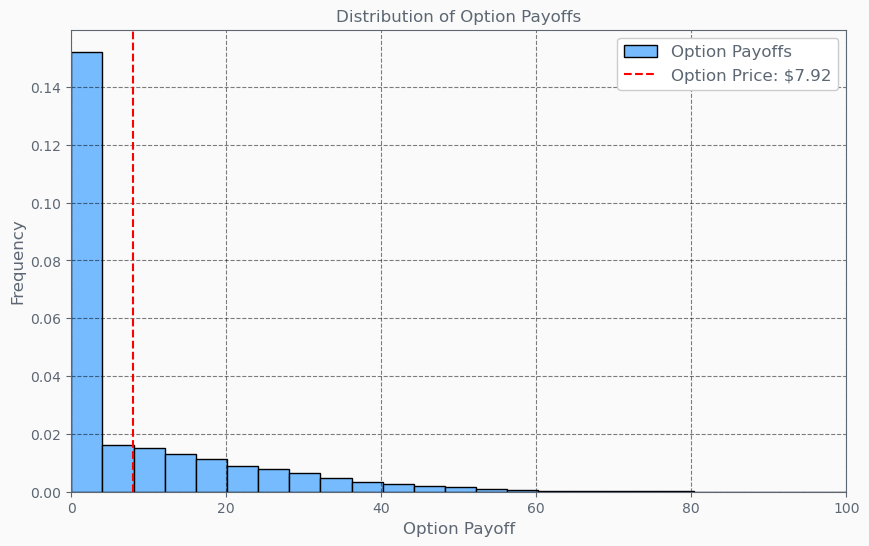

In [37]:
plt.figure(figsize=(10, 6))

plt.hist(option_payoffs, bins=30, edgecolor='k', density=True, label='Option Payoffs', color='#75bbfd')
plt.axvline(option_price, color='r', linestyle='--', label=f"Option Price: ${option_price:.2f}")

plt.xlim(0, 100)

plt.legend(loc=0, facecolor='white', framealpha=1, fontsize=12)
plt.xlabel("Option Payoff", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Option Payoffs")
plt.grid(True, linestyle='--', color='black', alpha=0.5)
# plt.savefig('option_payoff_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

---
# Comparison of Monte Carlo Simulation Model with Black-Scholes Model
---

## Black-Scholes Model

The **Black–Scholes model** [1] serves as a mathematical framework to comprehend the dynamics of derivative investments in financial markets. Utilizing the Black–Scholes equation, a parabolic partial differential equation, the model derives the Black–Scholes formula. This formula offers a theoretical valuation of European-style options, illustrating that each option possesses a distinct price determined by the security's risk. The expected return is replaced by the risk-neutral rate in calculations, highlighting the unique pricing of options within this framework.

The Black-Scholes Formula for the price of a call option is as followed:

$$ C = N(d_1)S_0 - N(d_2)Ke^{-rt} $$
$$ d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})t}{\sigma \sqrt{t}} $$
$$ d_2 = d_1 - \sigma \sqrt{t}$$

Where the corresponding parameters are:
- $C$ = option price
- $N$ = CDF of the Normal Distribution
- $S_0$ = The intial stock price
- $K$ = Strike price
- $r$ = risk-free interest rate
- $t$ = Time to maturity
- $\sigma$ = volatility of the asset

[1] Black, Fischer, and Myron Scholes. "The pricing of options and corporate liabilities." Journal of political economy 81.3 (1973): 637-654.
https://doi.org/10.1086/260062

### Function for calculating the option price using Black-Scholes model

In [17]:
def black_scholes_model(S0, K, r, volatility, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

### Example results

Model input parameters:

In [18]:
S0 = 100            # Initial stock price
K = 105             # Strike price
r = 0.05            # Risk-free interest rate
volatility = 0.2    # Annual volatility
T = 1               # Time to maturity (in years)

In [19]:
print(f'Black-Scholes Model Price: ${black_scholes_model(S0, K, r, volatility, T):.2f}')

Black-Scholes Model Price: $8.02


## Simulation of input data for model comparison

Parameters for input data are generated using the following assumption:
- Initial stock price ($S_0$) ~ $\mathcal{N}(100, 10)$
- Strike price (K) = $S_0$ + |$\alpha$|, where $\alpha$ ~ $\mathcal{N}(5, 2.5)$ 
- Risk-free interest rate (r) - based on US Treasury Yields for T years
- Volatility (volatility) ~ $\text{Lognormal}(0, 1)$ (based on [2])
- Time to maturity (T) ~ ${U}(\{0.5, 1, 2, 5, 10\})$

[2] Cizeau, Pierre, et al. "Volatility distribution in the S&P500 stock index." Physica A: Statistical Mechanics and its Applications 245.3-4 (1997): 441-445.

### Generation of input data

#### Generation parameters

In [20]:
number_of_samples = 200

risk_free_interest_rate_map = {
    0.5: 0.0521,
    1: 0.0474,
    2: 0.0425,
    5: 0.0388,
    10: 0.0397
}

Source for US Treasury Yields (Opened on: 11-01-2024): https://www.bloomberg.com/markets/rates-bonds/government-bonds/us


#### Generation of each parameter value

In [21]:
np.random.seed(0)

intial_stock_prices = np.random.normal(100, 10, number_of_samples)

strike_price_delta = np.random.normal(5, 2.5, number_of_samples)
strike_prices = [intial_stock_prices[i] + abs(strike_price_delta[i]) for i in range(number_of_samples)]

volatility_values = np.random.lognormal(0, 1, number_of_samples)

maturity_options = [0.5, 1, 2, 5, 10]
time_to_maturity_values = np.random.choice(maturity_options, number_of_samples)

rf_interest_rates = [risk_free_interest_rate_map[T] for T in time_to_maturity_values]

#### Input Data's Pandas DataFrame Initialization

In [22]:
input_data_df = pd.DataFrame({
    'Initial Stock Price': intial_stock_prices,
    'Strike Price': strike_prices,
    'Risk-free Interest Rate': rf_interest_rates,
    'Volatility': volatility_values,
    'Time to Maturity': time_to_maturity_values
})

In [23]:
input_data_df.head(5)

,Initial Stock Price,Strike Price,Risk-free Interest Rate,Volatility,Time to Maturity
0,117.640523,121.717569,0.0397,0.549551,10.0
1,104.001572,108.403124,0.0474,0.327621,1.0
2,109.787380,117.536529,0.0388,2.152572,5.0
3,122.408932,129.047091,0.0388,1.428026,5.0
4,118.675580,125.275909,0.0388,0.170582,5.0


#### Visualization of the Input Data's Continuous Features' Distribution

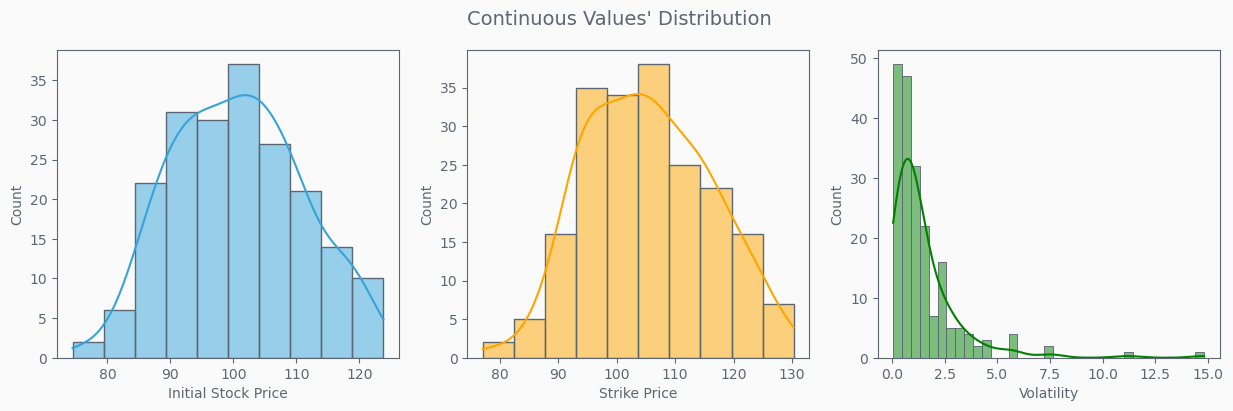

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle("Continuous Values' Distribution", fontsize=14)

sns.histplot(input_data_df['Initial Stock Price'], ax=axes[0], kde=True, label='Initial Stock Price')
sns.histplot(input_data_df['Strike Price'], ax=axes[1], kde=True, color='orange', label='Strike Price')
sns.histplot(input_data_df['Volatility'], ax=axes[2], kde=True, color='green', label='Volatility')

# plt.savefig('parameters.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Generation of option prices 

### Results Pandas DataFrame initialization

In [25]:
results_df = input_data_df.copy()

In [26]:
results_df.head()

,Initial Stock Price,Strike Price,Risk-free Interest Rate,Volatility,Time to Maturity
0,117.640523,121.717569,0.0397,0.549551,10.0
1,104.001572,108.403124,0.0474,0.327621,1.0
2,109.787380,117.536529,0.0388,2.152572,5.0
3,122.408932,129.047091,0.0388,1.428026,5.0
4,118.675580,125.275909,0.0388,0.170582,5.0


### Black-Scholes Model

In [27]:
def black_scholes_row(row):
    S0 = row['Initial Stock Price']
    K = row['Strike Price']
    r = row['Risk-free Interest Rate']
    volatility = row['Volatility']
    
    d1 = (np.log(S0 / K) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

In [28]:
results_df['Black-Scholes Model Price'] = input_data_df.apply(black_scholes_row, axis=1)

### Monte Carlo Simulation Model

In [29]:
num_simulations = 1000  # Number of paths / Number of Simulations
num_time_steps = 365    # Number of steps / Number of time intervals

In [30]:
def monte_carlo_row(row, num_simulations, num_time_steps):
    S0 = row['Initial Stock Price']
    K = row['Strike Price']
    r = row['Risk-free Interest Rate']
    volatility = row['Volatility']
    
    # Generate random stock price paths
    np.random.seed(0)  # for reproducibility
    dt = T / num_time_steps

    # Simulate stock price paths
    stock_price_paths_df = pd.DataFrame(np.full((num_simulations, 1), S0), columns=['0'])

    columns = [f'{i}' for i in range(num_time_steps + 1)]

    for i in range(1, num_time_steps + 1):
        z = np.random.standard_normal(num_simulations)
        coeff = np.exp((r - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * z)
        
        stock_price_paths_df = pd.concat([stock_price_paths_df, stock_price_paths_df[f'{i-1}'] * coeff], axis=1)
        stock_price_paths_df.columns = columns[:i+1]
        
    # Calculate option payoffs
    option_payoffs = [max(0, path[-1] - K) for path in stock_price_paths]

    # Calculate the option price using Monte Carlo
    option_price = np.exp(-r * T) * np.mean(option_payoffs)
    
    return option_price

In [31]:
results_df['Monte Carlo Model Price'] = input_data_df.apply(monte_carlo_row, axis=1, args=(num_simulations, num_time_steps))

### Visulization of results

In [32]:
results_df.head(5)

,Initial Stock Price,Strike Price,Risk-free Interest Rate,Volatility,Time to Maturity,Black-Scholes Model Price,Monte Carlo Model Price
0,117.640523,121.717569,0.0397,0.549551,10.0,25.730533,2.813713
1,104.001572,108.403124,0.0474,0.327621,1.0,13.803172,6.543444
2,109.787380,117.536529,0.0388,2.152572,5.0,78.392758,3.737556
3,122.408932,129.047091,0.0388,1.428026,5.0,63.830112,1.652792
4,118.675580,125.275909,0.0388,0.170582,5.0,7.245009,2.189034


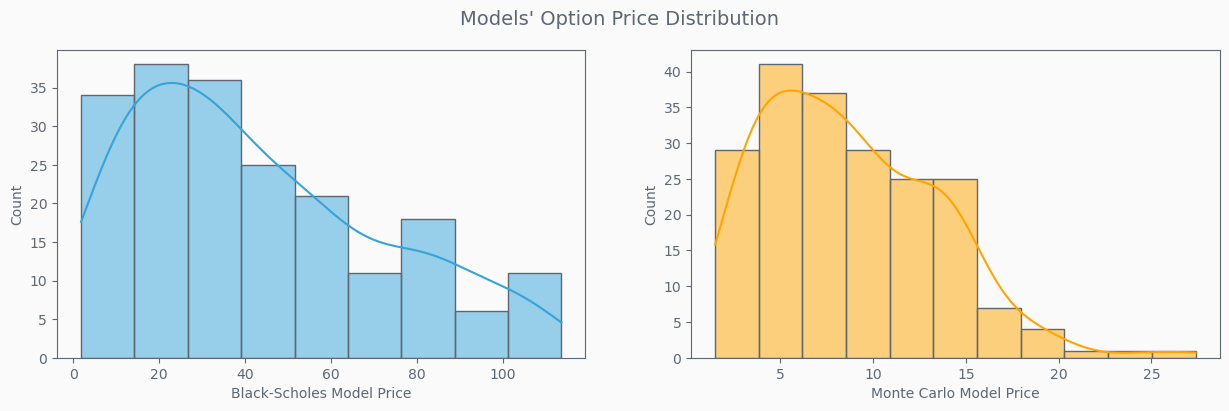

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle("Models' Option Price Distribution", fontsize=14)

sns.histplot(results_df['Black-Scholes Model Price'], ax=axes[0], kde=True)
sns.histplot(results_df['Monte Carlo Model Price'], ax=axes[1], kde=True, color='orange')

# plt.savefig('models_option_price_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Model Comparisons

In [34]:
# R^2 value
r_squared = np.corrcoef(results_df['Black-Scholes Model Price'], results_df['Monte Carlo Model Price'])[0, 1]**2
print(f'R^2 value: {r_squared:.2f}')

# Mean squared error
mean_squared_error = np.mean((results_df['Black-Scholes Model Price'] - results_df['Monte Carlo Model Price'])**2)
print(f'Mean squared difference: {mean_squared_error:.2f}')

# Mean absolute error
mean_absolute_error = np.mean(np.abs(results_df['Black-Scholes Model Price'] - results_df['Monte Carlo Model Price']))
print(f'Mean absolute difference: {mean_absolute_error:.2f}')

# Root mean squared error
root_mean_squared_error = np.sqrt(mean_squared_error)
print(f'Root mean squared difference: {root_mean_squared_error:.2f}')

R^2 value: 0.02
Mean squared difference: 2060.08
Mean absolute difference: 34.74
Root mean squared difference: 45.39


Based on the results:
- $R^2$ value: 0.02
- Mean squared difference: 2060.08
- Mean absolute difference: 34.74
- Root mean squared difference: 45.39

The correlation between the two models is very low. The Monte Carlo model is not a good approximation of the Black-Scholes model.

### Visualization of results

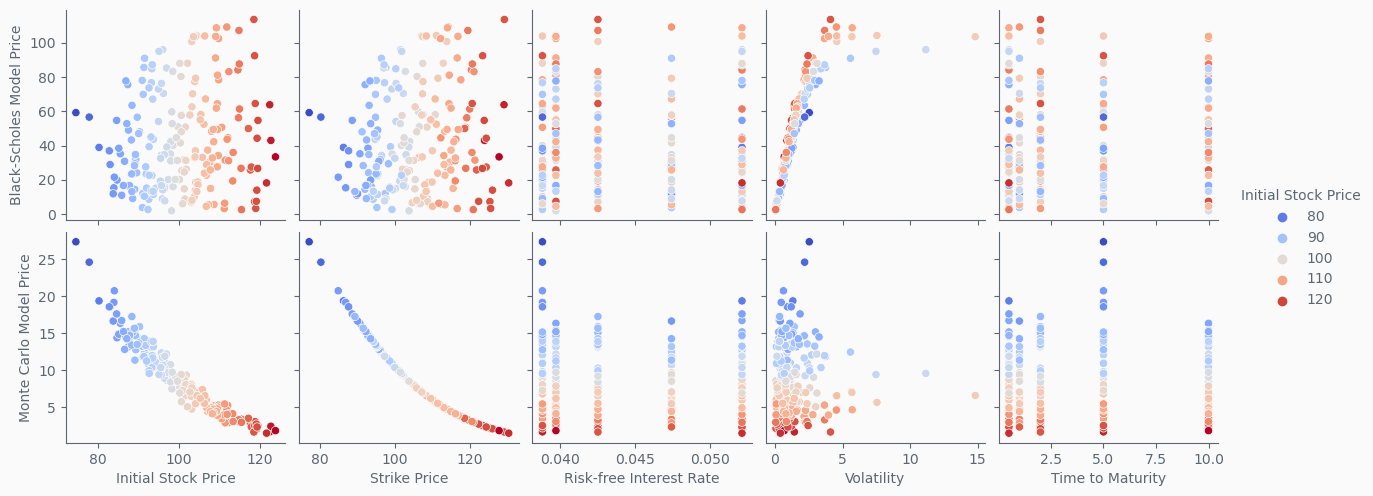

In [35]:
sns.pairplot(
    results_df,
    y_vars=['Black-Scholes Model Price', 'Monte Carlo Model Price'],
    x_vars=['Initial Stock Price', 'Strike Price', 'Risk-free Interest Rate', 'Volatility', 'Time to Maturity'],
    hue='Initial Stock Price',
    palette='coolwarm'
)

# plt.savefig('pairplot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

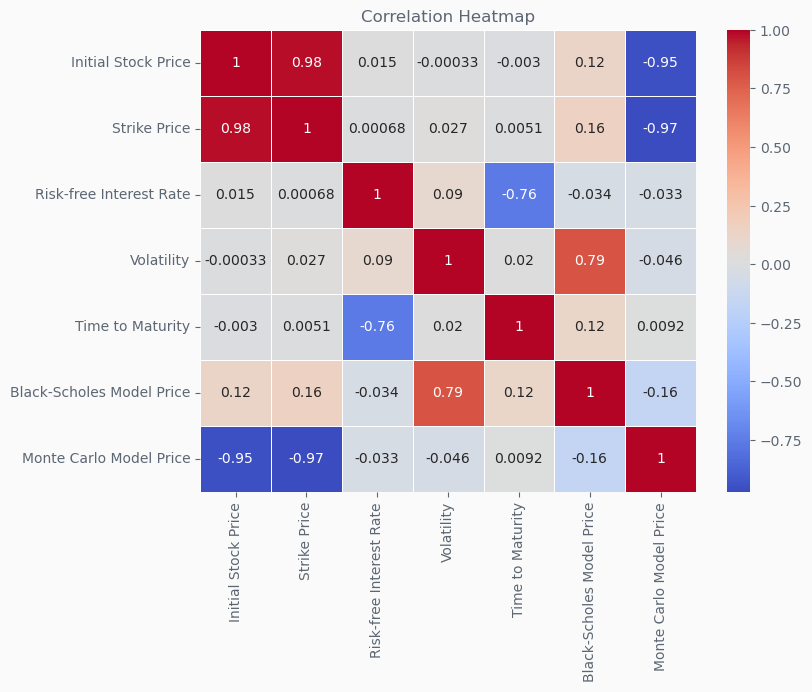

In [36]:
correlation_matrix = results_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')

# plt.savefig('correlation_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()